In [374]:
import pandas as pd
import requests
from time import sleep
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from src.core.votacao import TipoVoto
import seaborn as sns

In [3]:
projs = pd.read_excel(r"./projetos_selecionados.xlsx")
projs

,tipo,código,ano,tema,ementa,orientação
0,PEC,6,2019,reforma da previdência,"Modifica o sistema de previdência social, esta...",1
1,PL,3418,2021,fundebe,"Altera a Lei nº 14.113, de 25 de dezembro de 2...",1
2,PL,5829,2019,energia renovável,NOVA EMENTA: Institui o marco legal da microge...,1
3,PL,3179,2012,homeschooling,"Altera as Leis nºs 9.394, de 20 de dezembro de...",1


# Dados


In [257]:
df_parls = pd.read_csv("./data/parlamentares.csv")
df_parls["id_parl"] = [str(id_parl) for id_parl in df_parls["id_parl"]]

df_dim_prof = pd.read_excel("./data/dim_profissoes_ficha.xlsx")

df_parls_profs = pd.read_csv("./data/profissoes.csv")

df_profs_d = df_parls_profs[["id_parl", "cod_tipo_profissao", "titulo"]].merge(
    df_dim_prof[["codTipoProfissao", "is_empresario"]],
    left_on="cod_tipo_profissao",
    right_on="codTipoProfissao",
)
df_profs_d = (
    df_profs_d.join(pd.get_dummies(df_profs_d["cod_tipo_profissao"]))
    .groupby("id_parl")
    .max(numeric_only=True)
    .reset_index()
)

df_profs_d["id_parl"] = [str(id_parl) for id_parl in df_profs_d["id_parl"]]

df_parls = df_parls.merge(df_profs_d[["id_parl", "is_empresario"]], on="id_parl")

In [241]:
df_props = pd.DataFrame()
df_autores = pd.DataFrame()
df_votacoes = pd.DataFrame()
df_votos = pd.DataFrame()
df_orientacoes = pd.DataFrame()

for idx in projs.index:
    nome_tema = projs.loc[idx, "tema "]

    df_tema = pd.read_csv(f"./data/{nome_tema}/projetos.csv")
    df_tema["tema"] = nome_tema
    df_props = pd.concat([df_props, df_tema])

    df_tema = pd.read_csv(f"./data/{nome_tema}/autores.csv")
    df_tema["tema"] = nome_tema
    df_autores = pd.concat([df_autores, df_tema])

    df_tema = pd.read_csv(f"./data/{nome_tema}/votacoes.csv")
    df_tema["tema"] = nome_tema
    df_votacoes = pd.concat([df_votacoes, df_tema])

    df_tema = pd.read_csv(f"./data/{nome_tema}/votos.csv")
    df_tema["tema"] = nome_tema
    df_votos = pd.concat([df_votos, df_tema])

    df_tema = pd.read_csv(f"./data/{nome_tema}/orientacoes.csv").dropna(
        subset="orientacao_voto"
    )
    df_tema["tema"] = nome_tema
    df_orientacoes = pd.concat([df_orientacoes, df_tema])

df_votos["id_parl"] = [str(id_autor) for id_autor in df_votos["id_parl"]]
df_autores["id_autor"] = [str(id_autor) for id_autor in df_autores["id_autor"]]

## Governismo

In [242]:
df_ori_gov = df_orientacoes[
    df_orientacoes["sigla_partido_bloco"] == "Governo"
].reset_index(drop=True)
df_ori_gov["v_trat"] = df_ori_gov["orientacao_voto"].apply(
    lambda x: TipoVoto[x.upper()].value
)

In [244]:
df_v_m_g = df_votos.merge(df_ori_gov, on="id_votacao")
df_v_m_g["ori_g"] = df_v_m_g["voto_trat"] * df_v_m_g["v_trat"]

In [265]:
df_gov = (
    df_v_m_g.join(pd.get_dummies(df_v_m_g["ori_g"]))
    .groupby("id_parl")
    .agg({1: "sum", -1: "sum"})
    .reset_index()
)
df_gov['governismo'] = df_gov[1] / (df_gov[1] + df_gov[-1])

In [270]:
df_parls_gov = df_parls.merge(df_gov[["id_parl", "governismo"]], on="id_parl")
df_parls_gov = df_parls_gov[
    ["id_parl", "sigla_partido", "sigla_uf", "is_empresario", "governismo"]
].reset_index(drop=True)

---


# Descritivas


In [230]:
df_empres_by_partido = (
    df_parls.merge(df_profs_d[["id_parl", "is_empresario"]], on="id_parl")
    .groupby("sigla_partido")
    .agg({"id_parl": "count", "is_empresario": "sum"})
    .rename({"id_parl": "total", "is_empresario": "empresarios"}, axis=1)
    .sort_values("empresarios", ascending=False)
)
df_empres_by_partido["%"] = (
    df_empres_by_partido["empresarios"] / df_empres_by_partido["total"]
)
df_empres_by_partido

,total,empresarios,%
sigla_partido,,,
PP,131,63,0.480916
PSD,103,41,0.398058
MDB,119,40,0.336134
PL,85,31,0.364706
UNIÃO,64,25,0.390625
PT,134,23,0.171642
PR,44,19,0.431818
PSDB,93,17,0.182796
REPUBLICANOS,55,16,0.290909


---


# calcular Rice por tema


In [ ]:
idx = 0
for idx in projs.index:
    nome_tema = projs.loc[idx, "tema "]
    print(nome_tema)
    df_props = pd.read_csv(f"./data/{nome_tema}/projetos.csv")
    df_autores = pd.read_csv(f"./data/{nome_tema}/autores.csv")
    df_autores["id_autor"] = [str(id_autor) for id_autor in df_autores["id_autor"]]
    df_votacoes = pd.read_csv(f"./data/{nome_tema}/votacoes.csv")
    df_votos = pd.read_csv(f"./data/{nome_tema}/votos.csv")
    df_votos["id_parl"] = [str(id_autor) for id_autor in df_votos["id_parl"]]

    df_final = (
        df_votos[["id_parl", "sigla_partido", "id_votacao", "voto_trat"]]
        .merge(df_profs_d[["id_parl", "is_empresario"]], on="id_parl")
        .reset_index(drop=True)
    )
    # calcular rice
    df_rice = (
        df_final.join(pd.get_dummies(df_final["voto_trat"]))
        .groupby(["id_votacao", "is_empresario"])
        .agg(({-1: "sum", 1: "sum"}))
        .reset_index()
    )
    df_rice["rice"] = abs(df_rice[1] - df_rice[-1]) / (df_rice[1] + df_rice[-1])
    df_rice_g = df_rice.groupby("is_empresario")["rice"].agg(["count", "mean", "std"])

    # calcular rice de partidos similares
    partidos = list(df_empres_by_partido.index[:5])
    df_rice = (
        df_final[df_final["sigla_partido"].isin(partidos)]
        .join(pd.get_dummies(df_final["voto_trat"]))
        .groupby(["id_votacao", "is_empresario"])
        .agg(({-1: "sum", 1: "sum"}))
        .reset_index()
    )
    df_rice["rice"] = abs(df_rice[1] - df_rice[-1]) / (df_rice[1] + df_rice[-1])
    df2 = df_rice.groupby("is_empresario")["rice"].agg(["count", "mean", "std"])

    df_rice_g = df_rice_g.join(df2, rsuffix="_partidario")

    display(df_rice_g)
# df_votacoes.merge(df_props, on='id_prop', how='left').to_excel(f'votações_{nome_tema}.xlsx')


# df_merge = df_autores.merge(df_props, on="id_prop", how="left").merge(
#     df_profs_d, left_on="id_autor", right_on="id_parl", how="left"
# )

# df_group = df_merge.groupby("id_autor").agg(
#     {"is_empresario": "max", "id_prop": "count"}
# )

# df_plot = pd.DataFrame()
# df_plot["Não Empresários"] = [
#     g for g in df_group[df_group["is_empresario"] == 0]["id_prop"]
# ]
# df_ne = pd.DataFrame(
#     {"Empresários": [g for g in df_group[df_group["is_empresario"] == 1]["id_prop"]]}
# )

# df_plot = pd.concat([df_plot, df_ne], ignore_index=False, axis=1)

# print(projs.loc[idx, "tema "])
# display(df_plot.agg(["min", "max", "mean", "std", "count"]).round(decimals=2))

# fig, ax = plt.subplots()
# df_plot.plot.hist(ax=ax, alpha=0.8, bins=5)
# ax.set_ylabel("Freq.")
# ax.grid(axis="y")

# Pareamento


In [122]:
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *

In [276]:
df_psm = (
    df_parls_gov.join(pd.get_dummies(df_parls_gov["sigla_uf"], dtype=int, prefix="uf"))
    .join(pd.get_dummies(df_parls_gov["sigla_partido"], dtype=int, prefix="partido"))
    .reset_index(drop=True)
)

df_psm.drop(
    ["sigla_partido", "sigla_uf"],
    axis=1,
    inplace=True,
)

In [278]:
psm = PsmPy(df_psm, treatment="is_empresario", indx="id_parl")

psm.logistic_ps(balance=True)

psm.knn_matched(
    matcher="propensity_logit", replacement=False, caliper=None, drop_unmatched=True
)

In [296]:
matched = []
for treat, control in zip(psm.matched_ids["id_parl"], psm.matched_ids["matched_ID"]):
    matched.append(treat)
    matched.append(control)
print(len(matched))

568


## calcular rice com matched


In [372]:
df_final = (
    df_votos[["id_parl", "sigla_partido", "id_votacao", "voto_trat", "tema"]]
    .merge(df_profs_d[["id_parl", "is_empresario"]], on="id_parl")
    .reset_index(drop=True)
)
# calcular rice
df_rice = (
    df_final[df_final["id_parl"].isin(matched)]
    .join(pd.get_dummies(df_final["voto_trat"]))
    .groupby(["tema", "id_votacao", "is_empresario"])
    .agg(({-1: "sum", 1: "sum"}))
    .reset_index()
)
df_rice["rice"] = abs(df_rice[1] - df_rice[-1]) / (df_rice[1] + df_rice[-1])
df_rice_g = df_rice.groupby(["tema", "is_empresario"])["rice"].agg(["count", "mean", "std"])
display(df_rice_g)

count      mean       std
tema                   is_empresario                           
energia renovável      0                  3  0.781479  0.207533
                       1                  3  0.808419  0.219908
fundebe                0                  4  0.743108  0.195308
                       1                  4  0.779436  0.147402
homeschooling          0                 12  0.625489  0.105407
                       1                 12  0.633763  0.118667
reforma da previdência 0                 46  0.744175  0.190096
                       1                 46  0.756441  0.183270

<Axes: xlabel='rice', ylabel='tema'>

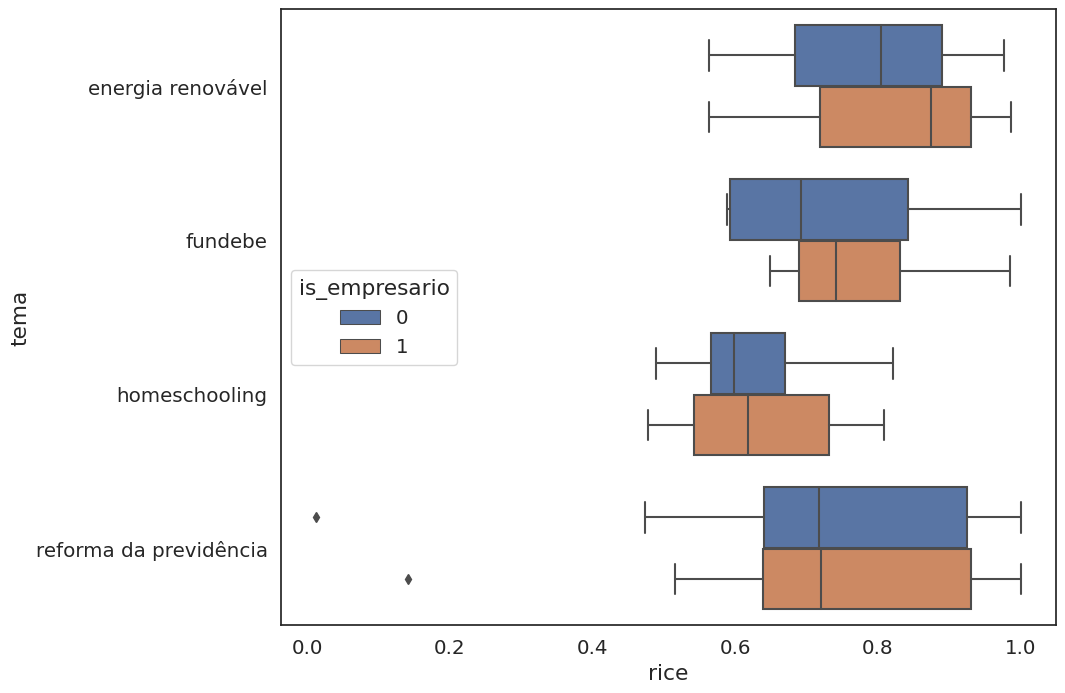

In [375]:
sns.boxplot(data=df_rice, x="rice", y="tema", hue="is_empresario")

## calcular rice com matching em votações divergentes

In [354]:
df_rice_votacoes = (
    df_votos.join(pd.get_dummies(df_votos["voto_trat"]))
    .groupby("id_votacao")
    .agg({1: "sum", -1: "sum"})
    .reset_index()
)

df_rice_votacoes["rice"] = abs(df_rice_votacoes[1] - df_rice_votacoes[-1]) / (
    df_rice_votacoes[1] + df_rice_votacoes[-1]
)

In [362]:
votacoes_divergentes = list(df_rice_votacoes.query("rice < .95")['id_votacao'])

In [369]:
df_final = (
    df_votos[df_votos["id_votacao"].isin(votacoes_divergentes)][
        ["id_parl", "sigla_partido", "id_votacao", "voto_trat", "tema"]
    ]
    .merge(df_profs_d[["id_parl", "is_empresario"]], on="id_parl")
    .reset_index(drop=True)
)
# calcular rice
df_rice = (
    df_final[df_final["id_parl"].isin(matched)]
    .join(pd.get_dummies(df_final["voto_trat"]))
    .groupby(["tema", "id_votacao", "is_empresario"])
    .agg(({-1: "sum", 1: "sum"}))
    .reset_index()
)
df_rice["rice"] = abs(df_rice[1] - df_rice[-1]) / (df_rice[1] + df_rice[-1])
df_rice_g = df_rice.groupby(["tema", "is_empresario"])["rice"].agg(["count", "mean", "std"])
display(df_rice_g)

count      mean       std
tema                   is_empresario                           
energia renovável      0                  3  0.781479  0.207533
                       1                  3  0.808419  0.219908
fundebe                0                  4  0.743108  0.195308
                       1                  4  0.779436  0.147402
homeschooling          0                 12  0.625489  0.105407
                       1                 12  0.633763  0.118667
reforma da previdência 0                 42  0.721311  0.183010
                       1                 42  0.735656  0.178063

# PLOT
